## Photometry on example PAL5 data

This notebook details an example of performing aperture photometry on real world PAL5 data in order to practice using photometry tools with Photutils and other useful tools such as AstroPy.

The following is a list of Python imports used with in this notebook:

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits # used for FITS file management
from astropy.stats import sigma_clipped_stats # used within star detection
from astropy.table import Table
from photutils import aperture_photometry # used to perform photometry using annuli
from photutils import DAOStarFinder # used for the star finding algorithm
from photutils import CircularAperture, CircularAnnulus

The next step is to now read in the FITS file of choice, designating this as the variable image and extracting some information from the header of the FITS file in order to convert flux values into counts.

In [2]:
image = 'PAL5_data\PAL5_3p6um.fits'

hdr_list = fits.open(image)
hdr = hdr_list[0].header
#print(hdr) # one can choose to print the header in order to identify the titles of certain aspects of the header

# assigning values from the header
fluxconv = hdr['FLUXCONV']
exptime = hdr['EXPTIME']
print(fluxconv, exptime)
hdr_list.close()

# retrieving data from the imported FITS file
image_data = fits.getdata(image, ext = 0)

# converting image_data into count data
conv_data = image_data * exptime / fluxconv

0.1469 3.71 969.101928711


In order to perform aperture photometry on the stars a source detection algorithm must be run. This algorithms detects the locations of the stars within the image based on parameters fed into the algorithm, such as the sigma value. In order to do this the number of stars detected has been plotted against various sigma values from 1 to 10 in order to identify the 'elbow' of the curve, which could indicate the best position between detecting false positive stars (much lower sigma values) and detecting false negative stars (which would mean the source detector isn't detecting stars).

Text(0, 0.5, 'stars detected')

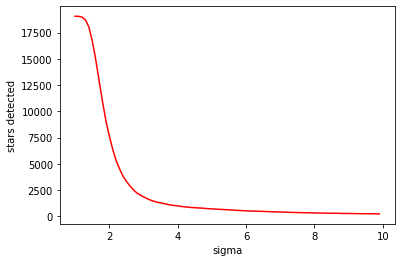

In [4]:
# for simplicity convdata is now being assigned merely data
data = conv_data

# declaring empty lists for each dimension of the plot
Nstar = []
sigma_val = []

# cycle through various sigma values, determining the number of stars detected for each value
for n in range(10, 100):
    mead, median, std = sigma_clipped_stats(data, sigma = n / 10)
    sigma_val.append(n * 0.1)
    sigma = n * 0.1
    # implementing source detection algorithm
    daofind = DAOStarFinder(fwhm = 3.0, threshold = sigma * std)
    sources = daofind(data - median)
    Nstar.append(len(sources))

# plot data
plt.plot(sigma_val, Nstar, c = 'r')
plt.xlabel(r'sigma')
plt.ylabel(r'stars detected')

Currently, when run, the above code contains many warnings due to NaNs in the data, these will be removed in later code; this was just an exercise to see what sort of sigma value may be best to use. From the graph and plotting the detected stars over the image, a value of 4 has been decided to be the best, for now.

The next code now continues with this value of sigma.

In [4]:
NaNmask = ~np.isnan(data)
datatest = data[NaNmask]

In [3]:
# redefining data in case the above code does not get run
data = conv_data

# perform sigma clipping
mean, median, std = sigma_clipped_stats(data, sigma = 4.)
print(mean, median, std)

# perfom source detection
daofind = DAOStarFinder(fwhm = 3.0, threshold = 4. * std)
sources = daofind(data - median)
print(sources)

328.6638488769531 316.47125244140625 90.65550994873047
 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 1374.7149632923192 ...  1.222278542647609 -0.21792546924675948
  2 1306.2872090933806 ...   1.15662667823781 -0.15798301331736073
  3 1193.3977569063193 ...  1.036585227182426 -0.03901253807994843
  4  875.5912015102731 ... 1.0629435815516077  -0.0662755346124239
  5 1269.2458300815101 ... 3.9537490440841414  -1.4925227498061078
  6   929.151784357753 ... 1.0941015246469292 -0.09764405807439369
  7 1140.0222376462668 ...  4.016190063974083  -1.5095356434238028
  8 1302.2448048712843 ...  7.449142532937185   -2.180265710513024
  9  890.4916392848608 ...  1.370596461233406 -0.34227401542606384
 10  989.5127680136554 ... 1.1318550111743502  -0.1344769949579601
...                ... ...                ...                  ...
988  900.5001174083449 ... 1.0597026133119232 -0.06296001335477922
989 107

By using sigma = 4, the source detection algorithm has detected 998 stars. The next stage is now to place annuli around each of these sources, remove the stars in which the annulus exits the image data (causing NaNs) and then perform photometry for each annulus.

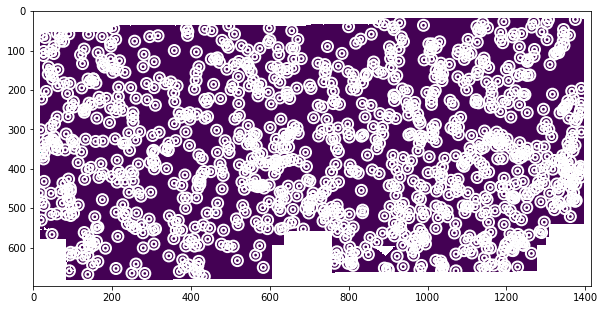

In [4]:
from astropy.visualization import simple_norm
from matplotlib.colors import LogNorm

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAnnulus(positions, r_in = 6, r_out = 14)

#norm = simple_norm(data, 'sqrt', percent = 99)

plt.imshow(data, cmap = 'viridis', interpolation = 'nearest')
apertures.plot(color = 'w', lw = 2)
plt.gcf().set_size_inches(10, 6)

In [5]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
circular_apertures = CircularAperture(positions, r = 6)
annulus_apertures = CircularAnnulus(positions, r_in = 6, r_out = 14)

apertures = [circular_apertures, annulus_apertures]
# initial aperture photometry table, with NaNs as photometry initial
phot_init = aperture_photometry(data, apertures)

# sequence for masking NaNs for each aperture
#NaNmask = ~np.isnan(phot_init['aperture_sum_0'])
#phot_init_tmp = phot_init[NaNmask]
# this is an intermediate table which still contains NaNs for the remaining column
# NaNmask process is repeated, obtaining final photometry table
#NaNmask = ~np.isnan(phot_init_tmp['aperture_sum_1'])
#phot = phot_init_tmp[NaNmask]
#print(phot)

# removing NaN masks will define phot as phot_init
phot = phot_init

Stars in which one or both apertures fall outside of the image data, therefore producing NaNs have now been removed from the data reducing it to 923 stars. The following code now obtains the background subtracted count values for each star:

In [6]:
# create an annulus mask to access pixel values within any aperture
annulus_masks = annulus_apertures.to_mask(method = 'center')
#mask = annulus_masks[0].data

# store a list contain background median values from sigma clipping of the masked data
bkg_median = []
for mask in annulus_masks:
    # apply the mask to the data
    annulus_data = mask.multiply(data)
    # extract a 1D array of data values, neglecting spatial positions of annulus masks
    #mask = annulus_masks[0].data
    annulus_data_1d = annulus_data[mask.data > 0]
    # remove NaNs
    #NaNmask = ~np.isnan(annulus_data_1d)
    #annulus_data_1d_masked = annulus_data_1d[NaNmask]
    # utilise sigma clipping for the annulus masks 
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)
# now add bkg_median, aperture background and aperture sum background values to photometry data
phot = aperture_photometry(data, circular_apertures)
phot['annulus_median'] = bkg_median
phot['aper_bkg'] = bkg_median * circular_apertures.area
phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']

for col in phot.colnames:
    phot[col].info.format = '%.8g'
print(phot)

 id  xcenter   ycenter  aperture_sum annulus_median  aper_bkg aper_sum_bkgsub
       pix       pix                                                         
--- --------- --------- ------------ -------------- --------- ---------------
  1  1374.715  21.00836          nan      767.60413 86813.981             nan
  2 1306.2872 21.691519          nan      941.07599 106433.19             nan
  3 1193.3978 26.582374    40170.307      418.83795 47369.456      -7199.1495
  4  875.5912 26.690492          nan      313.18938 35420.884             nan
  5 1269.2458 28.561557    92495.088      639.06165 72276.169       20218.918
  6 929.15178 29.723225    37404.056      294.53822 33311.488       4092.5678
  7 1140.0222 29.913012    68417.435      408.80429 46234.676       22182.759
  8 1302.2448 30.489824    157632.94      894.32312 101145.56       56487.382
  9 890.49164 34.446212    36457.077      312.03087  35289.86       1167.2173
 10 989.51277 35.887709    45001.038      316.91534 35842.281   

The background subtracted aperture counts have now been calculated for all 998 stars. The stars falling at the extremeties of the data, which produce NaNs, shall be removed from the data and then the counts converted back into flux values, before calculating their apparent magnitudes.

In [9]:
# removing NaNs from photometry data
NaNmask = ~np.isnan(phot['aper_sum_bkgsub'])
phot_a = phot[NaNmask]
# add apparent magnitude column, for some reason must be filled with nans
phot_a['apparent_mag'] = float('NaN')

# defining aperture correction for measured brightness to be multiplied by
aper_corr = 1.125

# zero-magnitude flux density: c.f. Reach et al. 2005
zeropoint_flux = 280.9
# convert into counts
zeropoint_counts = zeropoint_flux * exptime / fluxconv

# calculating apparent magnitude for each star detected using counts
for i in range(0, len(phot_a)):
    if phot_a['aper_sum_bkgsub'][i] >= 0:
        phot_a['apparent_mag'][i] = 18.8 - 2.5 * math.log10(phot_a['aper_sum_bkgsub'][i] * aper_corr)

print(phot_a)

# calulcating apparent magnitude for each star detected using flux
# uncorrected values
phot_b = phot_a

phot_b['bkgsub_flux'] = float('NaN')
phot_b['apparent_mag_flux'] = float('NaN')
for i in range(0, len(phot_b)):
    phot_b['bkgsub_flux'][i] = phot_b['aper_sum_bkgsub'][i] * fluxconv / exptime
    for i in range(0, len(phot_b)):
        if phot_b['bkgsub_flux'][i] >= 0:
            phot_b['apparent_mag_flux'][i] = 18.8 - 2.5 * math.log10(phot_b['bkgsub_flux'][i] * aper_corr)
    
print(phot_b)

 id  xcenter   ycenter  ...  aper_bkg aper_sum_bkgsub    apparent_mag   
       pix       pix    ...                                             
--- --------- --------- ... --------- --------------- ------------------
  3 1193.3978 26.582374 ... 47369.456      -7199.1495                nan
  5 1269.2458 28.561557 ... 72276.169       20218.918 7.9077239056158355
  6 929.15178 29.723225 ... 33311.488       4092.5678  9.642128990652571
  7 1140.0222 29.913012 ... 46234.676       22182.759   7.80707981282929
  8 1302.2448 30.489824 ... 101145.56       56487.382  6.792240082852739
  9 890.49164 34.446212 ...  35289.86       1167.2173  11.00423936345338
 10 989.51277 35.887709 ... 35842.281       9158.7572  8.767527329962325
 13 1125.1278 38.511314 ... 41401.311       9223.7591  8.759848817786304
 14 1263.9513 40.479416 ... 59810.146       14222.079  8.289711013672708
 15 912.11758 40.450665 ... 32184.845       16591.628   8.12239618760897
...       ...       ... ...       ...             .

Automation attempt

In [102]:
from astropy.io import fits

def GetData(image):
    '''imports FITS file and extracts data, converting into counts'''
    '''using header information, returns data as global variable'''
    global data
    image = image
    
    hdr_list = fits.open(image)
    hdr = hdr_list[0].header
    
    fluxconv = hdr['FLUXCONV']
    gain = hdr['GAIN']
    exptime = hdr['EXPTIME']
    hdr_list.close()
    
    image_data = fits.getdata(image, ext = 0)
    
    data = image_data * exptime / fluxconv
    
    return data

In [103]:
GetData('PAL5_data\PAL5_3p6um.fits')

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [108]:
data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [109]:
import numpy as np
from astropy.stats import sigma_clipped_stats
from photutils import aperture_photometry
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus

def SourceDetection(input_data, sigma_value, fwhm, r, r_in, r_out):
    # remove NaNs from input data
    NaNmask = ~np.isnan(input_data)
    data_mask = input_data[NaNmask]
    
    # perform sigma clipping for specified sigma value
    mean, median, std = sigma_clipped_stats(data_mask, sigma = sigma_value)
    # perform source detection for specified fwhm and sigma values
    daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma_value * std)
    sources = daofind(input_data - median)
    
    # defining positions of stars and creating circular apertures and annuli for use in photometry
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    circular_apertures = CircularAperture(positions, r = r)
    annulus_apertures = CircularAnnulus(positions, r_in = r_in, r_out = r_out)
    
    # annulus masking and background median calculation
    annulus_masks = annulus_apertures.to_mask(method = 'center')
   
    bkg_median = []
    for mask in annulus_masks:
        # apply the mask to input data
        annulus_data = mask.multiply(input_data)
        # extract a 1D array of data values, neglecting spatial positions of annulus masks
        annulus_data_1d = annulus_data[mask.data > 0]
        # remove NaNs to avoid warnings
        NaNmask = ~np.isnan(annulus_data_1d)
        annulus_data_1d_masked = annulus_data_1d[NaNmask]
        # utilise sigma clipping again
        _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d_masked)
        bkg_median.append(median_sigclip)

    bkg_median = np.array(bkg_median)
    # now add bkg_median, aperture background and aperture sum background values to photometry data
    phot = aperture_photometry(input_data, circular_apertures)
    phot['annulus_median'] = bkg_median
    phot['aper_bkg'] = bkg_median * circular_apertures.area
    phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']
    
    return phot

In [110]:
SourceDetection(data, 4., 3., 6, 6, 14)

id,xcenter,ycenter,aperture_sum,annulus_median,aper_bkg,aper_sum_bkgsub
,pix,pix,,,,
int32,float64,float64,float64,float64,float64,float64
1,1374.7149632923192,21.008360327906978,nan,767.6041259765625,86813.98138919458,nan
2,1306.2872090933806,21.691518891965945,nan,941.0759887695312,106433.18686037196,nan
3,1193.3977569063193,26.582373533759917,40170.30687903351,418.83795166015625,47369.456351285175,-7199.149472251665
4,875.5912015102731,26.69049177053626,nan,313.1893768310547,35420.88403565304,nan
5,1269.2458300815101,28.56155749921132,92495.0875492137,639.0616455078125,72276.16934586054,20218.918203353154
6,929.151784357753,29.7232250674127,37404.05604749364,294.53822326660156,33311.48826296685,4092.567784526793
7,1140.0222376462668,29.913012078793074,68417.4346046723,408.8042907714844,46234.67603917252,22182.758565499775
8,1302.2448048712843,30.489823776771562,157632.94363574625,894.3231201171875,101145.5619874437,56487.38164830256


In [111]:
phot

id,xcenter,ycenter,aperture_sum,annulus_median,aper_bkg,aper_sum_bkgsub
,pix,pix,,,,
int32,float64,float64,float64,float64,float64,float64
1,1374.715,21.00836,nan,767.60413,86813.981,nan
2,1306.2872,21.691519,nan,941.07599,106433.19,nan
3,1193.3978,26.582374,40170.307,418.83795,47369.456,-7199.1495
4,875.5912,26.690492,nan,313.18938,35420.884,nan
5,1269.2458,28.561557,92495.088,639.06165,72276.169,20218.918
6,929.15178,29.723225,37404.056,294.53822,33311.488,4092.5678
7,1140.0222,29.913012,68417.435,408.80429,46234.676,22182.759
8,1302.2448,30.489824,157632.94,894.32312,101145.56,56487.382
